# Part 3: Visualising Convolutional Networks

__Before starting, we recommend you enable GPU acceleration if you're running on Colab. You'll also need to upload the weights you downloaded previously using the following block and using the upload button to upload your bettercnn.weights file:__

In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer
    
try:
    from google.colab import files
    uploaded = files.upload()
except:
    print("Not running on colab. Ignoring.")

!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/2.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/3.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/4.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/5.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/6.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/7.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/8.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/9.PNG

Saving bettercnn.weights to bettercnn (1).weights
--2019-03-05 12:15:51--  http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [image/png]
Saving to: ‘0.PNG.2’

0.PNG.2             100%[===================>]   2.46K  --.-KB/s    in 0s      

2019-03-05 12:15:51 (401 MB/s) - ‘0.PNG.2’ saved [2514/2514]

--2019-03-05 12:15:52--  http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [image/png]
Saving to: ‘1.PNG.2’

1.PNG.2            

## Visualising the first layers filters and responses

In our previous `BetterCNN` convolutional network, the first layer was a Convolutional layer. Because this convolutional layer is applied directly to the greylevel input MNIST images the filters that are learned can themselves just be considered to be small (5x5 in this case) greylevel images. 

We'll start by doing a few imports and then loading our pre-trained model. Once again, please copy-paste the forward method from the first workbook:

In [0]:
%matplotlib inline
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn

import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

# build the model and load state
model = BetterCNN()
model.load_state_dict(torch.load('bettercnn.weights'))

We can extract the weights of the first layer filters directly from the trained network and visualise them using `matplotlib` like this:

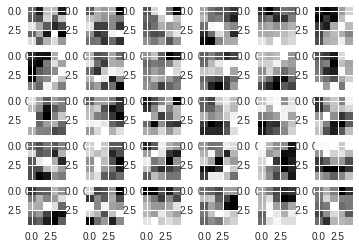

In [0]:
from scipy.misc import imread

weights = model.conv1.weight.data.cpu()

# plot the first layer features
for i in range(0,30):
	plt.subplot(5,6,i+1)
	plt.imshow(weights[i, 0, :, :], cmap=plt.get_cmap('gray'))
plt.show()

Note that `model.conv1.data` is the tensor holding the weights. Calling `cpu()` ensures data is moved over from the GPU if necessary.

__Answer the following question (enter the answer in the box below):__

__1.__ What sort of features do the filters resemble? How does this relate to your knowledge of the training data?

Some weights look like random noise to me, but some are trying to catch lines and round borders

## Visualising feature maps

If we forward propagate an input through the network we can also visualise the response maps generated by the filters. The advantage of this kind of visualisation is that we can compute it at any layer, not just the first one. In order to do this in PyTorch, we can propagate the given input through the network to the required point and use a `hook` to intercept the feature maps as they are created. The following code shows how this can be achieved to generate the response maps of the second convolutional layer of our network:

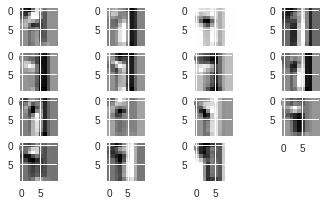

In [0]:
from PIL import Image
import torchvision

transform = torchvision.transforms.ToTensor()
im = transform(Image.open("1.PNG")).unsqueeze(0)

def hook_function(module, grad_in, grad_out):
    for i in range(grad_out.shape[1]):
        conv_output = grad_out.data[0, i]
        plt.subplot(5, int(1+grad_out.shape[1]/5), i+1)
        plt.imshow(conv_output, cmap=plt.get_cmap('gray'))
        
hook = model.conv2.register_forward_hook(hook_function) # register the hook
model(im) # forward pass
hook.remove() #Tidy up

__Use the following code block to visualise the feature maps of the first convolutional layer__:

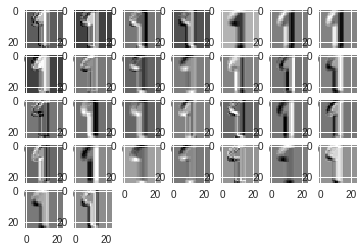

In [0]:
transform = torchvision.transforms.ToTensor()
im = transform(Image.open("1.PNG")).unsqueeze(0)

def hook_function(module, grad_in, grad_out):
    for i in range(grad_out.shape[1]):
        conv_output = grad_out.data[0, i]
        plt.subplot(5, int(1+grad_out.shape[1]/5), i+1)
        plt.imshow(conv_output, cmap=plt.get_cmap('gray'))
        
hook = model.conv1.register_forward_hook(hook_function) # register the hook
model(im) # forward pass
hook.remove() #Tidy up

A final way of visualising what the filters (at any depth) are learning is to find the input image that maximises the response of the filter. We can do this by starting with a random image and using gradient ascent to optimise the image to maximise the chosen filter (see http://www.iro.umontreal.ca/~lisa/publications2/index.php/publications/show/247 and https://distill.pub/2017/feature-visualization/ for more info on this approach). The following code snippet shows how this can be achieved:

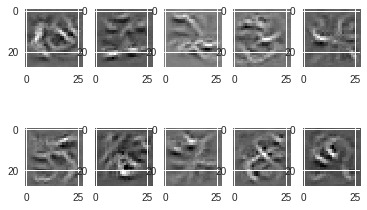

In [0]:
def visualise_maximum_activation(model, target, num=10, alpha = 1.0):
    for selected in range(num):
        input_img = torch.randn(1, 1, 28, 28, requires_grad=True)

        # we're interested in maximising outputs of the 3rd layer:
        conv_output = None

        def hook_function(module, grad_in, grad_out):
            nonlocal conv_output
            # Gets the conv output of the selected filter/feature (from selected layer)
            conv_output = grad_out[0, selected]

        hook = target.register_forward_hook(hook_function)

        for i in range(30):
            model(input_img)
            loss = torch.mean(conv_output)
            loss.backward()

            norm = input_img.grad.std() + 1e-5
            input_img.grad /= norm
            input_img.data = input_img + alpha * input_img.grad

        hook.remove()

        input_img = input_img.detach()

        plt.subplot(2,num/2,selected+1)
        plt.imshow(input_img[0,0], cmap=plt.get_cmap('gray'))

    plt.show()
    
visualise_maximum_activation(model, model.fc3)